In [1]:
import numpy as np
import pandas as pd
import sys
import os
import random

sys.path.insert(0, '..')

from unpast.run_unpast import unpast
from unpast.utils.method import prepare_input_matrix
from unpast.utils.consensus import make_consensus_biclusters

from unpast.utils.eval import make_ref_groups
from unpast.utils.eval import calculate_perfromance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from collections import OrderedDict

exprs_file = "../../data/preprocessed_v6/multiomics/TCGA-BRCA_PanCan_518_all_29K.tsv.gz"

exprs= pd.read_csv(exprs_file,sep = "\t",index_col=0)

subt_anno = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep ="\t",index_col=0)
anno = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep ="\t",index_col=0)
shared_samples = set(exprs.columns).intersection(set(anno.index))
print(len(shared_samples))
exprs = exprs.loc[:,sorted(shared_samples)]
subt_anno = subt_anno.loc[sorted(shared_samples),:]

subt_order = ["Her2","Basal","LumA","LumB","Normal"]

color_dict = OrderedDict()

color_dict["PAM50"] = OrderedDict({"Her2":"yellow",
                                   "Basal":"lightblue",
                                   "LumA":"lightgreen",
                                   "LumB":"darkgreen",
                                   "Normal":"grey"})

color_dict["CL"] = OrderedDict({1:"magenta",0:"grey"}) # claudin-low

color_dict["sex"] = OrderedDict({1:"lightpink",0:"lightblue",
                                 "F":"lightpink","M":"lightblue"})

subt_anno["sex"] = "F"
subt_anno["CL"] = subt_anno["claudin_low"]


# histology
receptors = OrderedDict({'Positive':"red",
                         "Equivocal":"lightgrey",#"orange",
                         'Indeterminate':"lightgrey",#"gold",
                         'Negative':"green",
                         "NA":"lightgrey"})
color_dict["HER2"] = receptors
color_dict["ER"] = receptors 
color_dict["PR"] = receptors 
color_dict["IHC_receptor"] = OrderedDict({'Positive':"red",
                                      'Negative':"green",
                         "Indeterminate/Equivocal/NA":"lightgrey"})

for r in ['ER',"PR","HER2"]:
     subt_anno[r] = anno["IHC_"+r]
subt_anno = subt_anno.fillna("NA")

subt_anno.head(2)

518


,PAM50,claudin_low,SCMOD2,SCMOD1,intClust,AIMS,AURKA,ESR1,ERBB2,Desmedt2008_ESR1,...,PIK3CA,rorS,rorS_risk,NET_km,NET_w,sex,CL,ER,PR,HER2
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALI-01,Her2,0,HER2+,HER2+,1,Her2,10.6689,7.1768,18.4282,2.287569,...,2.304907,93.869507,3,0,0,F,0,Positive,Positive,Positive
TCGA-3C-AALK-01,LumA,0,HER2+,HER2+,1,LumA,8.6073,12.0650,15.9389,2.498951,...,2.510134,18.221834,1,0,0,F,0,Positive,Positive,Positive


In [4]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


#### Expression only
 - subset of 518 samples for which multi-omics are available

In [5]:
exprs_file = "../../data/preprocessed_v6/multiomics/TCGA-BRCA_PanCan_518_exprs_17K.tsv"
basename = "BRCA518_exprs"


subtypes = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
annotation = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep = "\t",index_col=0)

exprs_z= prepare_input_matrix(pd.read_csv(exprs_file,sep = "\t",index_col=0),ceiling=3)

subtypes = subtypes.loc[exprs.columns.values,:]
annotation = annotation.loc[exprs.columns.values,:]

known_groups, freqs = make_ref_groups(subtypes, annotation,exprs)

# Multi-omics

In [6]:
exprs_file = "../../data/preprocessed_v6/multiomics/TCGA-BRCA_PanCan_518_all_29K.tsv.gz"
basename = "BRCA518_multi"

out_dir = "../../multiomics_results2/"

subtypes = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
annotation = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep = "\t",index_col=0)

subtypes = subtypes.loc[exprs.columns.values,:]
annotation = annotation.loc[exprs.columns.values,:]

known_groups, freqs = make_ref_groups(subtypes, annotation,exprs)

In [7]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
from unpast.utils.io import read_bic_table

In [8]:
biclusters_multi = []
for seed in seeds:
    bic_file = out_dir+"/"+basename+".seed="+str(seed)+suffix
    if os.path.exists(bic_file):
        results = read_bic_table(bic_file)
    else:
        results = unpast(exprs_file, basename,
                      out_dir=out_dir,
                      load=False,
                      seed = seed,
                      verbose = False
                     )    
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters_multi.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 1262
seed = 403958	n_biclusters: 1357
seed = 794772	n_biclusters: 1370
seed = 933488	n_biclusters: 1337
seed = 441001	n_biclusters: 1321


In [9]:
exprs = pd.read_csv(exprs_file,sep="\t",index_col = 0)

# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z_multi = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
consensus_biclusters_multi = make_consensus_biclusters(biclusters_multi, 
                                                       exprs_z_multi, 
                                                        seed = analysis_seed,
                                                        verbose = True,
                                                        plot = False
                                                        )

consensus_biclusters_multi.head(3)

2861 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 116.26 s.
	modules: 1416, not clustered features 225 
		similarity cutoff: 0.43 modularity: 0.999
keep genes included in at least 2 merged biclusters
all consensus biclusters: 1629
detected 2+ times:1398
162 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,14.311528,2,5,"{NPHP4_sm, SPAG17_sm}","{TCGA-EW-A1J5-01, TCGA-E9-A22E-01, TCGA-D8-A27...","{NPHP4_sm, SPAG17_sm}",{},"{18309, 18782}","{416, 419, 326, 395, 435}",UP,5,"{seed=403958_130, seed=441001_4, seed=933488_2..."
1,14.251655,2,5,"{GOLGA4_sm, DNAH6_sm}","{TCGA-D8-A27G-01, TCGA-D8-A27V-01, TCGA-D8-A1X...","{GOLGA4_sm, DNAH6_sm}",{},"{18859, 18196}","{326, 298, 207, 435, 316}",UP,3,"{seed=794772_3, seed=933488_60, seed=885440_72}"
2,13.021314,2,5,"{ATXN1_sm, PCDH15_sm}","{TCGA-D8-A27V-01, TCGA-3C-AALI-01, TCGA-AO-A12...","{ATXN1_sm, PCDH15_sm}",{},"{18953, 18233}","{0, 326, 107, 302, 435}",UP,2,"{seed=794772_1278, seed=441001_1120}"


In [10]:
from unpast.utils.io import write_bic_table
write_bic_table(consensus_biclusters_multi, out_dir+"/"+basename+".analysis_seed="+str(analysis_seed)+".kmeans.consensus.biclsuters.tsv")

In [11]:
# or read precomputed
#from unpast.utils.io import read_bic_table
#exprs_z_multi = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
#consensus_biclusters_multi = read_bic_table(out_dir+"/"+basename+".analysis_seed="+str(analysis_seed)+".kmeans.consensus.biclsuters.tsv")

In [12]:
# all omics 
performances_multi = {}
best_matches = {}
for i in range(len(seeds)):
    p, bm  = calculate_perfromance(biclusters_multi[i], 
                                   known_groups,
                                   set(exprs_z_multi.columns.values),
                                   performance_measure="ARI")
    performances_multi[seeds[i]] = p
    best_matches[seeds[i]] = bm
    
p, bm = calculate_perfromance(consensus_biclusters_multi,
                              known_groups,
                              set(exprs_z_multi.columns.values),
                              performance_measure="ARI")
performances_multi["consensus"] = p
best_matches["consensus"] = bm
pd.DataFrame.from_dict(performances_multi).T

,PAM50,Intrinsic,PAM50_AB,SCMOD2,IHC,Luminal,Basal,Her2,LumA,LumB,Normal,Claudin-low,IHC_HER2,IHC_ER,IHC_PR,IHC_TNBC,NET_kmeans,NET_ward
885440,0.745554,0.716568,0.488569,0.518834,0.493379,0.751680,0.935322,0.581736,0.492659,0.223401,0.159560,0.139065,0.520162,0.571903,0.402455,0.471061,0.689039,0.662296
403958,0.731281,0.702977,0.499911,0.538591,0.493030,0.737404,0.935322,0.556579,0.520115,0.239710,0.105982,0.139065,0.520162,0.571336,0.402231,0.471061,0.686744,0.546279
794772,0.750187,0.721096,0.488221,0.530566,0.494153,0.758851,0.944313,0.556579,0.492596,0.223401,0.166870,0.141513,0.520162,0.572460,0.402676,0.477046,0.770149,0.662296
933488,0.742228,0.713517,0.490183,0.518543,0.487211,0.744531,0.944313,0.581736,0.492659,0.223401,0.159560,0.141513,0.497661,0.565432,0.397339,0.477046,0.635228,0.536624
441001,0.755157,0.725829,0.503821,0.528753,0.494153,0.766043,0.944313,0.556579,0.531446,0.223401,0.166870,0.141513,0.520162,0.572460,0.402676,0.477046,0.737596,0.716640
consensus,0.720378,0.692711,0.503524,0.526539,0.459581,0.716148,0.944313,0.556579,0.531446,0.223401,0.159560,0.141513,0.520162,0.527685,0.367462,0.477046,0.721904,0.614452


In [13]:
#best_matches["consensus"] 

In [14]:
g = "ERBB2"
consensus_biclusters_multi[consensus_biclusters_multi["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
59,2.648744,7,45,"{hsa-miR-4728-3p, STARD3, GRB7, PGAP3, ERBB2, ...","{TCGA-3C-AALK-01, TCGA-AR-A1AT-01, TCGA-BH-A1F...","{hsa-miR-4728-3p, STARD3, GRB7, PGAP3, ERBB2, ...",{},"{17963, 14285, 5966, 10736, 11665, 17624, 4574}","{0, 1, 257, 512, 513, 390, 135, 263, 264, 138,...",UP,5,"{seed=794772_67, seed=403958_74, seed=933488_8..."


In [18]:
bic_stats = {}
bic_stats['miRNA'] = consensus_biclusters_multi["genes"].apply(lambda genes: len([g for g in genes if "hsa-" in g]))
bic_stats['methylation'] = consensus_biclusters_multi["genes"].apply(lambda genes: len([g for g in genes if "cg" in g]))
bic_stats["protein expr."] = consensus_biclusters_multi["genes"].apply(lambda genes: len([g for g in genes if "_RPPA" in g]))
bic_stats["mutations"] = consensus_biclusters_multi["genes"].apply(lambda genes: len([g for g in genes if "_sm" in g]))
bic_stats = pd.DataFrame.from_dict(bic_stats)
bic_stats["n_genes"] =  consensus_biclusters_multi["n_genes"]
omics_types = ['miRNA','methylation',"protein expr.","mutations"]
bic_stats["mRNA expr."] =  bic_stats["n_genes"] - bic_stats.loc[:,omics_types].sum(axis=1)
omics_types = ["mRNA expr.",'miRNA','methylation',"protein expr.","mutations"]

bic_stats["omics"] = ""
bic_stats["n_omics"] = 0
for o in ["mRNA expr.",'miRNA','methylation',"protein expr.","mutations"]:
    bic_stats.loc[bic_stats[o]>0,"omics"] += " "+o
    bic_stats.loc[bic_stats[o]>0,"n_omics"] += 1 
bic_stats.loc[bic_stats["n_omics"]>1,omics_types+["n_omics","omics","n_genes"]].sort_values(by = ["n_omics","n_genes"], ascending=[False,False]).head(60)

,mRNA expr.,miRNA,methylation,protein expr.,mutations,n_omics,omics,n_genes
78,90,0,52,2,1,4,mRNA expr. methylation protein expr. mutations,145
815,45,1,336,0,0,3,mRNA expr. miRNA methylation,382
73,145,8,18,0,0,3,mRNA expr. miRNA methylation,171
1218,16,2,1,0,0,3,mRNA expr. miRNA methylation,19
960,11,0,0,1,1,3,mRNA expr. protein expr. mutations,13
59,5,1,0,1,0,3,mRNA expr. miRNA protein expr.,7
27,24,0,6,0,0,2,mRNA expr. methylation,30
1332,26,1,0,0,0,2,mRNA expr. miRNA,27
1258,1,0,25,0,0,2,mRNA expr. methylation,26
430,12,2,0,0,0,2,mRNA expr. miRNA,14


In [48]:
mo_features = set(exprs_z_multi.index.values).difference(set(exprs_z.index.values))

Text(0.5, 31.99999999999997, 'TCGA-BRCA n=518 samples')

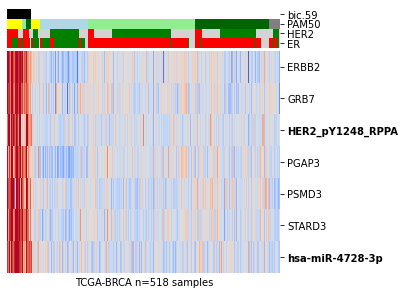

In [23]:
from unpast.utils.figs import draw_heatmap2
i = [59]
tmp = draw_heatmap2(exprs_z_multi,
                    consensus_biclusters_multi.loc[i,],
                    annot=subt_anno.loc[:,["PAM50","HER2","ER"]],
              color_dict=color_dict,
              figsize=(6,4),
              #no_legend=True,
              bic_prefix="bic.",
              no_cbar=True,
              col_labels = False,
              no_row_colors=True,
              cluster_rows=False,
              row_labels = True,
              dendrogram_ratio=(0.1,0.),
              colors_ratio=(0.025,0.05/4*3),
              highlight_row_labels= mo_features
             )

ax = tmp[0].ax_heatmap
ax.set_xlabel("TCGA-BRCA n=%s samples"%exprs_z_multi.shape[1])
#ax.set_ylabel(ax.get_ylabel(),fontdict={"size":7})

Text(462.42499999999995, 0.5, '')

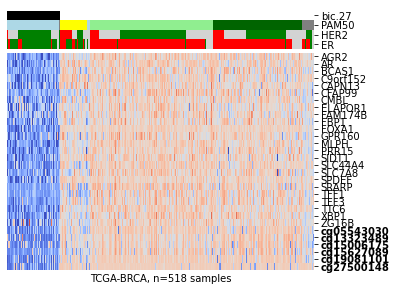

In [24]:
from unpast.utils.figs import draw_heatmap2
i = [27]
tmp = draw_heatmap2(exprs_z_multi,
                    consensus_biclusters_multi.loc[i,],
                    annot=subt_anno.loc[:,["PAM50","HER2","ER"]],
              color_dict=color_dict,
              figsize=(6,4),
              #no_legend=True,
              bic_prefix="bic.",
              no_cbar=True,
              col_labels = False,
              no_row_colors=True,
              cluster_rows=False,
              row_labels = True,
              dendrogram_ratio=(0.1,0.),
              colors_ratio=(0.025,0.05/4*3),
              highlight_row_labels= mo_features
             )

ax = tmp[0].ax_heatmap
ax.set_xlabel("TCGA-BRCA, n=%s samples"%exprs_z_multi.shape[1])
ax.set_ylabel(ax.get_ylabel(),fontdict={"size":7})

[]

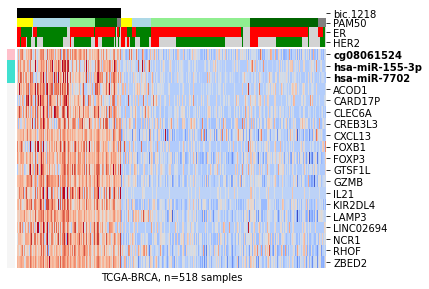

In [25]:
def draw_heatmap2(
    exprs,
    biclusters=pd.DataFrame(),
    annot=None,
    color_dict=None,
    figsize=(20, 10),
    dendrogram_ratio=(0.01, 0.2),  # space for dendrogram
    colors_ratio=(0.005, 0.02),
    bicluster_colors="black",  #
    no_bic_columns=False,  # do not show bicluster annotation in columns
    legend_n_cols=0,  # how many columns in legend; default - 0, no legend
    no_cbar=False,
    cluster_rows=True,
    cluster_cols=False,  # enable hierarchical clustering of columns
    cluster_columns=True,
    xlabel="samples",
    col_labels=True,
    row_labels=False,
    color_range=(-3, 3),
    bic_prefix="bic_",
    plot_bg_genes=False,
    no_row_colors=True,
    add_row_colors = pd.DataFrame(),
    highlight_row_labels=[],
    row_labels_black=False,
):
    """* exprs - expressions of genes to plot
       * biclusters in UnPaSt format
       * annot - annotation for samples, columns - subtypes, rows - samples 
       * color_dict - how to color each label
       * bicluster_colors - color for bicluster annotation "black","auto" or list 
       """
    bic_names = []
    ordered_genes = []
    row_colors = None
    col_colors = None
    sample_order = exprs.columns.values
    if type(annot) != type(None):
        cols = list(annot.columns.values)
        if not no_row_colors:
            row_colors = pd.DataFrame(
                data="white",
                index=exprs.index.values,
                columns=[bic_prefix + str(x) for x in biclusters.index.values],
            )

    else:
        annot = pd.DataFrame(index=exprs.columns)
        if not no_row_colors:
            row_colors = pd.DataFrame(index=exprs.index.values)
        cols = []
    if type(color_dict) != type(None):
        pass

    # list of bicluster colors
    if biclusters.shape[0] > 0:
        bic_colors = []
        if bicluster_colors == "black" or bicluster_colors == "redblue":
            bic_colors = ["black"] * biclusters.shape[0]
        elif bicluster_colors == "auto":
            palette = sns.color_palette("colorblind")
            # Get the first n colors from the palette
            bic_colors = sns.color_palette("colorblind",biclusters.shape[0]).as_hex()
            print("colors:", bic_colors)

        else:
            bic_colors = bicluster_colors
        bic_colors = dict(zip(biclusters.index.values, bic_colors))


        for row in biclusters.iterrows():
            bic_id = bic_prefix + str(row[0])
            s = row[1]["samples"]
            g_up = sorted(row[1]["genes_up"])
            g_down = sorted(row[1]["genes_down"])
            
            # if feature/row colors are set
            if add_row_colors.shape[0]>0:
                for rc_col in add_row_colors.columns:
                    rcs = sorted(set(add_row_colors[rc_col].values))
                    g_up_sorted = []
                    g_down_sorted = []
                    for rc in rcs:
                        g_ = set(add_row_colors.loc[add_row_colors[rc_col]==rc,:].index)
                        # up
                        g_up_sorted += sorted(g_.intersection(set(g_up)))
                        #down
                        g_down_sorted += sorted(g_.intersection(set(g_down)))
                g_up_sorted += sorted(set(g_up).difference(g_up_sorted))
                g_down_sorted += sorted(set(g_down).difference(g_down_sorted))
                g = g_up_sorted + g_down_sorted
            else:
                g = g_up + g_down

            annot[bic_id] = "white"
            annot.loc[list(s), bic_id] = bic_colors[row[0]]

            if not no_row_colors:
                row_colors.loc[g, bic_id] = bic_colors[row[0]]

            g = [x for x in g if not x in ordered_genes]
            ordered_genes += g
            bic_names.append(bic_id)
    else:
        plot_bg_genes = True

    if plot_bg_genes:
        ordered_genes = ordered_genes + sorted(
            set(exprs.index.values).difference(set(ordered_genes))
        )

    col_colors = annot.loc[:, bic_names + cols]

    for col in reversed(cols):
        col_color_map = color_dict[col]
        col_colors[col] = col_colors[col].apply(lambda x: col_color_map[x])
        for subt in list(col_color_map.keys()):
            subt_samples = annot.loc[annot[col] == subt, :].index
            if cluster_columns:
                new_sample_order = [
                    x for x in sample_order if x not in subt_samples
                ] + [x for x in sample_order if x in subt_samples]
                sample_order = new_sample_order

    for col in reversed(bic_names):
        ordered_colors = [x for x in set(annot[col]) if not x == "white"] + ["white"]
        for subt in ordered_colors:
            subt_samples = annot.loc[annot[col] == subt, :].index
            if cluster_columns:
                new_sample_order = [
                    x for x in sample_order if x not in subt_samples
                ] + [x for x in sample_order if x in subt_samples]
                sample_order = new_sample_order

    # change column colors if redblue is chosen
    if bicluster_colors == "redblue":
        bic_ids = biclusters.loc[biclusters["direction"] == "UP", :].index.values
        bic_ids = [bic_prefix + str(bic_id) for bic_id in bic_ids]
        d = {"black": "red", "white": "blue"}
        col_colors.loc[:, bic_ids] = col_colors.loc[:, bic_ids].applymap(lambda x: d[x])
        bic_ids = biclusters.loc[biclusters["direction"] == "DOWN", :].index.values
        bic_ids = [bic_prefix + str(bic_id) for bic_id in bic_ids]
        d = {"black": "blue", "white": "red"}
        col_colors.loc[:, bic_ids] = col_colors.loc[:, bic_ids].applymap(lambda x: d[x])

    if no_bic_columns:
        col_colors = col_colors.loc[:, cols]

    if add_row_colors.shape[1]>0:
        if type(row_colors) == type(pd.DataFrame()) and row_colors.shape[1]>0:
            row_colors = pd.concat([add_row_colors,
                                   row_colors.loc[add_row_colors.index.values,:]])
        else:
             row_colors = add_row_colors
    vmin, vmax = color_range

    g = sns.clustermap(
        exprs.loc[ordered_genes, sample_order],
        figsize=figsize,
        col_cluster=cluster_cols,
        row_cluster=cluster_rows,
        dendrogram_ratio=dendrogram_ratio,
        colors_ratio=colors_ratio,
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        vmin=vmin,
        vmax=vmax,
        xticklabels=col_labels,
        yticklabels=row_labels,
        col_colors=col_colors,
        row_colors=row_colors,
    )
    ax = g.ax_heatmap
    ax.set_ylabel("")
    ax.set_xlabel(xlabel)

    g.ax_row_dendrogram.set_visible(False)
    # g.cax.set_position([.10, .2, .03, .45])
    # from https://stackoverflow.com/questions/47350879/seaborn-clustermap-subplots-adjust-cancels-colour-bar-relocation
    dendro_box = g.ax_row_dendrogram.get_position()
    dendro_box.x0 = (dendro_box.x0 + 2 * dendro_box.x1) / 3
    g.cax.set_position(dendro_box)
    # Move the ticks to the left (https://stackoverflow.com/a/36939552/1878788)
    g.cax.yaxis.set_ticks_position("left")

    if no_cbar:
        g.ax_cbar.set_visible(False)

    # If there are row labels to highlight, format them in bold
    if highlight_row_labels:
        for row_tick in g.ax_heatmap.get_yticklabels():
            if row_tick.get_text() in highlight_row_labels:
                row_tick.set_weight("bold")
                for bic_id in biclusters.index.values:
                    if row_tick.get_text() in biclusters.loc[bic_id, "genes"]:
                        if not row_labels_black:
                            row_tick.set_color(bic_colors[bic_id])
    if legend_n_cols>0:
        legends = []
        n_patches = 0
        for col in cols:
            patches = []
            col_color_map = color_dict[col]
            # add patches only for groups found in annotation
            plot_groups = [x for x in col_color_map.keys() if x in set(annot[col].values)]
            for group in plot_groups:
                p = g.ax_col_dendrogram.bar(
                    0, 0, color=col_color_map[group], label=group, linewidth=0
                )
                patches.append(p)

            # add the legend
            n_patches += len(patches)
            l = g.ax_col_dendrogram.legend(loc="best", 
                                            ncol=legend_n_cols,
                                            bbox_transform=gcf().transFigure
                                            )
            legends.append(l)   
    return g, sample_order, (row_colors, col_colors)

row_color_dict = {
    "sm": "darkviolet",
    "meth": "pink",
    "rppa": "orange",
    "miRNA": "turquoise",
    "mRNA": "whitesmoke"
}


row_color_df = pd.DataFrame(["white"]*exprs_z_multi.shape[0],
                           index= exprs_z_multi.index, columns=["feature_group"],
                           )


row_color_df.loc[exprs_z.index,"feature_group"] = row_color_dict["mRNA"]
row_color_df.loc[[x for x in exprs_z_multi.index if x.startswith("cg")],"feature_group"] = row_color_dict["meth"]
row_color_df.loc[[x for x in exprs_z_multi.index if x.startswith("rs")],"feature_group"] = row_color_dict["meth"]
row_color_df.loc[[x for x in exprs_z_multi.index if x.endswith("_sm")],"feature_group"] = row_color_dict["sm"]
row_color_df.loc[[x for x in exprs_z_multi.index if x.startswith("hsa-")],"feature_group"] = row_color_dict["miRNA"]
row_color_df.loc[[x for x in exprs_z_multi.index if x.endswith("_RPPA")],"feature_group"] = row_color_dict["rppa"]

#from unpast.utils.figs import draw_heatmap2
i = [1218] 
tmp = draw_heatmap2(exprs_z_multi,
                    consensus_biclusters_multi.loc[i,],
                    annot=subt_anno.loc[:,["PAM50","ER","HER2"]],
              color_dict=color_dict,
              figsize=(6,5),#(10,5), 
              #no_legend=True,
              bic_prefix="bic.",
              no_cbar=True,
              col_labels = False,
              no_row_colors=True,
              cluster_rows=False,
              row_labels = True,
              dendrogram_ratio=(0.01,0.),
              colors_ratio=(0.025,0.05/4*3), # (0.015,0.05/4*3)
              highlight_row_labels= mo_features,
                add_row_colors=row_color_df
             )

g = tmp[0]
g.ax_heatmap.set_xlabel("TCGA-BRCA, n=%s samples"%exprs_z_multi.shape[1])
#g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontdict={"size":9})
g.ax_row_colors.set_xticklabels("")
g.ax_row_colors.set_xticks([])
#plt.savefig("../../img/Supplementary_Figs/multiomics_Luminal_bm.pdf")
#plt.savefig("../../img/Supplementary_Figs/multiomics_Luminal_bm.svg")
#plt.savefig("../../img/Supplementary_Figs/multiomics_newFOXP3_bm.pdf")
#plt.savefig("../../img/Supplementary_Figs/multiomics_newFOXP3_bm.svg")

[]

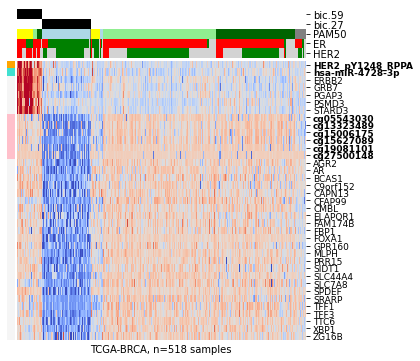

In [27]:
i = [59,27] 
tmp = draw_heatmap2(exprs_z_multi,
                    consensus_biclusters_multi.loc[i,],
                    annot=subt_anno.loc[:,["PAM50","ER","HER2"]],
              color_dict=color_dict,
              figsize=(6,6),
              #no_legend=True,
              bic_prefix="bic.",
              no_cbar=True,
              col_labels = False,
              no_row_colors=True,
              cluster_rows=False,
              row_labels = True,
              dendrogram_ratio=(0.01,0.),
              colors_ratio=(0.025,0.03),
              highlight_row_labels= mo_features,
                add_row_colors=row_color_df
             )

g = tmp[0]
g.ax_heatmap.set_xlabel("TCGA-BRCA, n=%s samples"%exprs_z_multi.shape[1])
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontdict={"size":9})
g.ax_row_colors.set_xticklabels("")
g.ax_row_colors.set_xticks([])
#plt.savefig("../../img/Supplementary_Figs/multiomics_Her2Basal_bm.pdf")
#plt.savefig("../../img/Supplementary_Figs/multiomics_Her2Basal_bm.svg")

In [30]:
" ".join(sorted(consensus_biclusters_multi.loc[59,"genes_up"].intersection(mo_features)))

'HER2_pY1248_RPPA hsa-miR-4728-3p'

In [31]:
" ".join(sorted(consensus_biclusters_multi.loc[78,"genes_down"].intersection(mo_features)))

'ERALPHA_RPPA GATA3_RPPA'

In [32]:
" ".join(sorted(consensus_biclusters_multi.loc[78,"genes_up"].intersection(mo_features)))

'TP53_sm cg00208274 cg00629117 cg01798157 cg02580209 cg02654411 cg03555299 cg04017512 cg04330597 cg04583813 cg04813697 cg04896832 cg05348366 cg06174882 cg06746774 cg07385362 cg07770222 cg08435683 cg09787089 cg09804858 cg10024484 cg10036013 cg10501210 cg10505610 cg11599864 cg12542255 cg13251533 cg13378781 cg13466694 cg15732530 cg16074271 cg16375820 cg16508600 cg17763019 cg17953300 cg18804777 cg19007141 cg19505458 cg19604703 cg19884556 cg20349803 cg21779805 cg22581896 cg22729681 cg23076870 cg23440816 cg23752752 cg24170465 cg24222580 cg24365896 cg25306932 cg25373630 cg26819718'

[]

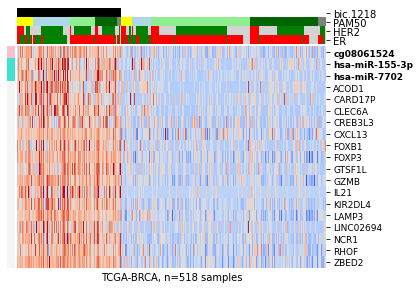

In [33]:
#from unpast.utils.figs import draw_heatmap2
i = [1218]
tmp = draw_heatmap2(exprs_z_multi,
                    consensus_biclusters_multi.loc[i,],
                    annot=subt_anno.loc[:,["PAM50","HER2","ER"]],
              color_dict=color_dict,
              figsize=(6,5),
              #no_legend=True,
              bic_prefix="bic.",
              no_cbar=True,
              col_labels = False,
              no_row_colors=True,
              cluster_rows=False,
              row_labels = True,
              dendrogram_ratio=(0.01,0.),
              colors_ratio=(0.025,0.035),
              highlight_row_labels= mo_features,
              add_row_colors=row_color_df
             )

g = tmp[0]
ax=g.ax_heatmap
ax.set_xlabel("TCGA-BRCA, n=%s samples"%exprs_z_multi.shape[1])
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontdict={"size":9})
g.ax_row_colors.set_xticklabels("")
g.ax_row_colors.set_xticks([])
#plt.savefig("../../img/Supplementary_Figs/multiomics_newFOXP3_bm.pdf")
#plt.savefig("../../img/Supplementary_Figs/multiomics_newFOXP3_bm.svg")

In [34]:
i = 1218
consensus_biclusters_multi.loc[i,"genes"]
print("\n".join(sorted([x for x in consensus_biclusters_multi.loc[i,"genes"] if not "cg" in x])))

ACOD1
CARD17P
CLEC6A
CREB3L3
CXCL13
FOXB1
FOXP3
GTSF1L
GZMB
IL21
KIR2DL4
LAMP3
LINC02694
NCR1
RHOF
ZBED2
hsa-miR-155-3p
hsa-miR-7702


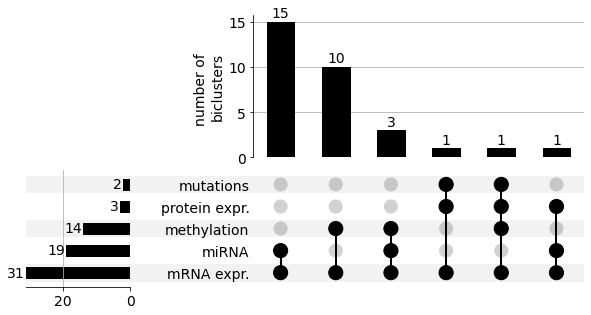

In [35]:
from upsetplot import UpSet
import matplotlib

data = bic_stats.loc[bic_stats["n_omics"]>1,omics_types].copy()
data = data/data
data= data.fillna(0)

# Convert binary DataFrame into a format suitable for UpSet
upset_data = data.astype(bool).groupby(list(data.columns)).size()

# Create and display UpSet plot
matplotlib.rcParams["font.size"] = 14
fig = plt.figure(figsize=(10, 5))
upset = UpSet(upset_data, sort_by='cardinality',show_counts=True,
              element_size=None)
upset.plot(fig=fig)
plt.ylabel("number of \nbiclusters")
#plt.savefig("../../img/Supplementary_Figs/multiomics_multiomics_stats2.pdf")
#plt.savefig("../../img/Supplementary_Figs/multiomics_multiomics_stats2.svg")
plt.show()

In [36]:
data = bic_stats.loc[:,omics_types+["omics"]].copy()
data["single or mutli-omics"] = "multi-omics"
for o in omics_types:
    data.loc[data["omics"]==" "+o,"single or mutli-omics"]=o

bic_counts = data.loc[:,["omics","single or mutli-omics"]].groupby("single or mutli-omics").agg("count").to_dict()['omics']
bic_counts

{'mRNA expr.': 117,
 'methylation': 1141,
 'miRNA': 17,
 'multi-omics': 31,
 'mutations': 91,
 'protein expr.': 1}

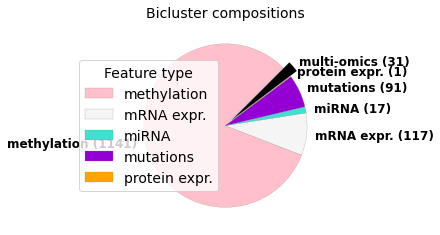

In [37]:
labels  = ['methylation','mRNA expr.', 'miRNA', 'mutations', 'protein expr.', 'multi-omics']
color_dict["omics"] = {'methylation':"pink",
              'mRNA expr.':"whitesmoke",
              'miRNA':"turquoise", 
              'mutations':"darkviolet", 
              'protein expr.':"orange", 
              'multi-omics':"black"}
sizes = [bic_counts[l] for l in labels]

# Use Seaborn Set3 palette
#colors = sns.color_palette("Set3", len(bic_counts))
colors = [color_dict["omics"][l] for l in labels]


# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(sizes,
        labels=[f"{label} ({bic_counts[label]})" for label in labels], 
        colors=colors, 
        #autopct=None,
        explode=(0,0, 0,0,0,0.1),
        #pctdistance=0.6, 
        startangle=45,
        #autopct='%.1f%%',
       wedgeprops={'linewidth': 0.2, 'edgecolor': 'grey'},
       textprops={'size': 'x-large'})
ax.set_title("Bicluster compositions", fontsize=14)

plt.setp(texts, size=12, weight="bold")

ax.legend(wedges[:-1], labels[:-1],
          title="Feature type",
          loc="best",
          ncols = 1,
          #frameon = False,
          bbox_to_anchor=(0, 0, 0.5, 1)
         )

plt.tight_layout()
#plt.savefig("../../img/Supplementary_Figs/multiomics_multiomics_stats1.pdf")
#plt.savefig("../../img/Supplementary_Figs/multiomics_multiomics_stats1.svg")
plt.show()


In [38]:
color_dict["omics"] = {
              'mRNA expr.':"whitesmoke",
              'miRNA':"turquoise",
              'methylation':"pink", 
              'protein expr.':"orange", 
              'mutations':"darkviolet",}

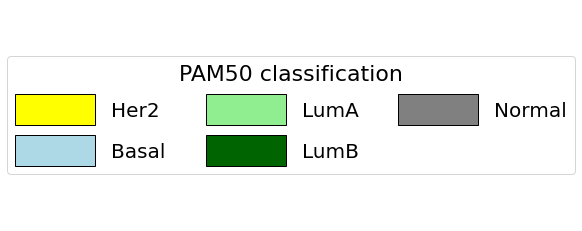

In [39]:
from matplotlib.patches import Patch
cat = "PAM50"#"IHC_receptor"#"omics"#"PAM50"#"omics"

legend_elements = []
for subt in color_dict[cat].keys():
    p = Patch(facecolor=color_dict[cat][subt], edgecolor='black', label=subt)
    legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots() # figsize = (3,2)
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=3,
    handlelength=4,
    handleheight=2,
    title='',  # Legend title
    fontsize=20  # Legend items font size
)

#legend.get_frame().set_alpha(0)

#legend.set_title('Feature type', prop={'size': 22})
legend.set_title('PAM50 classification', prop={'size': 22})
#legend.set_title('receptor status (IHC)', prop={'size': 22})
plt.savefig("../../img/Fig6/legend_cd_PAM50.svg")

ax.axis('off')

plt.show()


# Expression only
 - subset of 518 samples for which multi-omics are available

In [40]:
exprs_file = "../../data/preprocessed_v6/multiomics/TCGA-BRCA_PanCan_518_exprs_17K.tsv"
basename = "BRCA518_exprs"

subtypes = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
annotation = pd.read_csv("../../data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep = "\t",index_col=0)

exprs_z= prepare_input_matrix(pd.read_csv(exprs_file,sep = "\t",index_col=0),ceiling=3)

subtypes = subtypes.loc[exprs.columns.values,:]
annotation = annotation.loc[exprs.columns.values,:]

known_groups, freqs = make_ref_groups(subtypes, annotation,exprs)

In [41]:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                  out_dir=out_dir,
                  load=False,
                  seed = seed,
                  verbose = False
                 )
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 232
seed = 403958	n_biclusters: 225
seed = 794772	n_biclusters: 239
seed = 933488	n_biclusters: 230
seed = 441001	n_biclusters: 240


In [42]:
consensus_biclusters = make_consensus_biclusters(biclusters, exprs_z, 
                                                seed = analysis_seed,
                                                verbose = True,
                                                plot = False
                                                )

consensus_biclusters.head(3)

91 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 0.81 s.
	modules: 242, not clustered features 93 
		similarity cutoff: 0.43 modularity: 0.995
keep genes included in at least 2 merged biclusters
all consensus biclusters: 337
detected 2+ times:240
10 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,4.424893,3,5,"{GRXCR1, MIR124-2HG, POTEA}","{TCGA-E9-A22G-01, TCGA-D8-A1JP-01, TCGA-E9-A24...","{GRXCR1, MIR124-2HG, POTEA}",{},"{8768, 6019, 11237}","{396, 400, 56, 57, 286}",UP,3,"{seed=441001_2, seed=403958_0, seed=933488_4}"
1,3.761919,109,6,"{LHFPL4, ASTN2-AS1, SNORA10, DEFB108B, SNORD55...","{TCGA-A7-A26I-01, TCGA-E9-A245-01, TCGA-A7-A26...","{LHFPL4, ASTN2-AS1, SNORA10, SNORD55, DEFB108B...",{},"{6662, 10251, 13836, 5645, 13838, 15375, 2063,...","{400, 56, 57, 59, 60, 63}",UP,5,"{seed=933488_0, seed=885440_0, seed=441001_0, ..."
2,2.900207,51,89,"{FOXA1, RANBP3L, ARHGEF38, HMGCS2, XBP1, ABCC1...","{TCGA-OL-A5D7-01, TCGA-LL-A8F5-01, TCGA-E2-A1B...",{},"{FOXA1, RANBP3L, ARHGEF38, HMGCS2, XBP1, ABCC1...","{14850, 2947, 7430, 17160, 17161, 15755, 10896...","{7, 8, 12, 14, 15, 29, 36, 44, 46, 47, 50, 52,...",DOWN,5,"{seed=885440_2, seed=794772_1, seed=441001_1, ..."


In [43]:
# only expression
performances = {}
best_matches_exprs = {}
for i in range(len(seeds)):
    p, bm  = calculate_perfromance(biclusters[i], 
                                    known_groups,
                                    set(exprs_z.columns.values),
                                   performance_measure="ARI")
    performances[seeds[i]] = p
    best_matches_exprs[seeds[i]] = bm
p, bm = calculate_perfromance(consensus_biclusters,
                              known_groups,
                              set(exprs_z.columns.values),
                              performance_measure="ARI")
performances["consensus"] = p
best_matches_exprs["consensus"] = bm
pd.DataFrame.from_dict(performances).T

,PAM50,Intrinsic,PAM50_AB,SCMOD2,IHC,Luminal,Basal,Her2,LumA,LumB,Normal,Claudin-low,IHC_HER2,IHC_ER,IHC_PR,IHC_TNBC,NET_kmeans,NET_ward
885440,0.737760,0.709146,0.488703,0.498316,0.473178,0.737717,0.953621,0.565641,0.455393,0.269129,0.15956,0.139065,0.505542,0.547351,0.382620,0.471061,0.684757,0.704370
403958,0.720617,0.692940,0.490332,0.510742,0.478849,0.716495,0.944313,0.556579,0.503534,0.216550,0.15956,0.141513,0.520162,0.552551,0.387188,0.477046,0.706865,0.599751
794772,0.727100,0.698364,0.505456,0.503096,0.478039,0.730621,0.926041,0.556579,0.514764,0.264535,0.15956,0.125853,0.520162,0.553148,0.387419,0.460714,0.676577,0.558906
933488,0.725491,0.697581,0.512216,0.526521,0.483815,0.723548,0.944313,0.556579,0.520115,0.269129,0.15956,0.141513,0.520162,0.558981,0.392250,0.477046,0.664538,0.558906
441001,0.730480,0.702214,0.502347,0.516566,0.478219,0.730621,0.935322,0.572547,0.514679,0.242243,0.16687,0.139065,0.512168,0.553148,0.387419,0.471061,0.704654,0.679626
consensus,0.731798,0.703586,0.504721,0.526754,0.478649,0.730621,0.944313,0.572547,0.520115,0.238349,0.15956,0.141513,0.512168,0.553148,0.387419,0.477046,0.753520,0.645685


In [44]:
(performances_multi["consensus"]["PAM50"]-performances["consensus"]["PAM50"])/performances["consensus"]["PAM50"]

-0.01560620902746753

In [45]:
performances["consensus"]["PAM50"], performances_multi["consensus"]["PAM50"]

(0.7317983224143605, 0.7203777248288119)

In [47]:
#from unpast.utils.io import write_bic_table
write_bic_table(consensus_biclusters, out_dir+"/"+basename+".analysis_seed="+str(analysis_seed)+".kmeans.consensus.biclsuters.tsv")